In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [31]:
train_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
sample = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')

In [32]:
print(train_df.shape)
train_df.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [33]:
print(test_df.shape)
test_df.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [34]:
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [35]:
print(categories.shape)
categories.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [36]:
print(shops.shape)
shops.head()

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


There are 2935849 rows in the train_df, 22170 items, 84 categories and 60 shops.

In [37]:
print(train_df['shop_id'].nunique())
print(train_df['item_id'].nunique())
print(items['item_category_id'].nunique())

60
21807
84


TEST

In [38]:
set(test_df.shop_id.value_counts().index).difference(set(shops.shop_id))

set()

In [39]:
set(test_df.item_id.value_counts().index).difference(set(items.item_id))

set()

In [40]:
# set(test_df.item_id.value_counts().index).difference(set(train_df.item_id))
len(set(test_df.item_id.value_counts().index).difference(set(train_df.item_id)))

363

Some items do not exist in the training sample

In [41]:
train_df.date = pd.to_datetime(train_df.date, format='%d.%m.%Y').dt.date

print(f'Total days: {len(train_df.date.value_counts())}')
print(f'From: {train_df.date.min()}')
print(f'To: {train_df.date.max()}')

Total days: 1034
From: 2013-01-01
To: 2015-10-31


In [46]:
idx = train_df.copy()

In [48]:
idx = (
    idx.groupby(["shop_id", "item_id", "date_block_num", "item_price"])
    .agg(["count"])
    .reset_index()
    .set_index(["shop_id", "item_id", "date_block_num"])
)
idx[idx.index.duplicated(keep=False)]

item_price  date item_cnt_day
                                          count        count
shop_id item_id date_block_num                              
0       51      0                  127.00     1            1
                0                  130.00     1            1
        2678    1                  734.00     2            2
                1                  808.00     2            2
        2748    0                  589.00     4            4
...                                   ...   ...          ...
59      22088   22                  99.00     2            2
        22092   2                  103.55     1            1
                2                  109.00     1            1
                24                 139.00     2            2
                24                 159.00     1            1

[224484 rows x 3 columns]

Outlier

In [52]:
# pd.DataFrame(train_df['item_price'].sort_values())
train_df['item_price'].value_counts().sort_index()

-1.0000            1
 0.0700            2
 0.0875            1
 0.0900            1
 0.1000         2932
                ... 
 42990.0000        4
 49782.0000        1
 50999.0000        1
 59200.0000        1
 307980.0000       1
Name: item_price, Length: 19993, dtype: int64

In [55]:
train_df.loc[train_df['item_price'].idxmax()]

date              2013-12-13
date_block_num            11
shop_id                   12
item_id                 6066
item_price          307980.0
item_cnt_day             1.0
Name: 1163158, dtype: object

In [56]:
items.loc[train_df.loc[train_df['item_price'].idxmax()].item_id]

item_name           Radmin 3  - 522 лиц.
item_id                             6066
item_category_id                      75
Name: 6066, dtype: object

In [57]:
series = train_df["item_price"]

Q1 = series.quantile(0.25)
Q3 = series.quantile(0.75)
IQR = Q3 - Q1

train_df[((series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR)))].shape

(258942, 6)

In [58]:
low = series.quantile(0.01)
high = series.quantile(0.99)

train_df[(series < low) | (series > high)].shape

(35033, 6)

<AxesSubplot:>

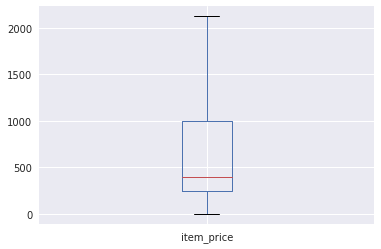

In [59]:
train_df["item_price"].plot(kind="box", showfliers=False)

In [61]:
with pd.option_context('display.float_format', lambda x: '%.2f' % x):
    print(train_df['item_price'].describe())

count   2935849.00
mean        890.85
std        1729.80
min          -1.00
25%         249.00
50%         399.00
75%         999.00
max      307980.00
Name: item_price, dtype: float64


Could be enought to just drop negative price and one very big sale

<AxesSubplot:>

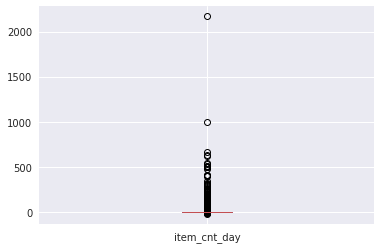

In [62]:
train_df["item_cnt_day"].plot(kind="box")

In [64]:
train_df['item_cnt_day'].value_counts().sort_index()

-22.0      1
-16.0      1
-9.0       1
-6.0       2
-5.0       4
          ..
 624.0     1
 637.0     1
 669.0     1
 1000.0    1
 2169.0    1
Name: item_cnt_day, Length: 198, dtype: int64

In [65]:
train_df.loc[train_df['item_cnt_day'].idxmax()]

date              2015-10-28
date_block_num            33
shop_id                   12
item_id                11373
item_price          0.908714
item_cnt_day          2169.0
Name: 2909818, dtype: object

In [66]:
items.loc[train_df.loc[train_df['item_cnt_day'].idxmax()].item_id]

item_name           Доставка до пункта выдачи (Boxberry)
item_id                                            11373
item_category_id                                       9
Name: 11373, dtype: object

In [63]:
with pd.option_context("display.float_format", lambda x: "%.2f" % x):
    print(train_df["item_cnt_day"].describe())

count   2935849.00
mean          1.24
std           2.62
min         -22.00
25%           1.00
50%           1.00
75%           1.00
max        2169.00
Name: item_cnt_day, dtype: float64


In [68]:
shops.loc[train_df.loc[train_df['item_cnt_day'].idxmax()].shop_id]

shop_name    Интернет-магазин ЧС
shop_id                       12
Name: 12, dtype: object

In [69]:
# train_df[train_df['item_id'] == train_df.loc[train_df['item_cnt_day'].idxmax()].item_id]['item_cnt_day'].mean()

14.144396551724139

In [93]:
train = train_df.copy()
print(f'Before: {train_df.shape}')
train = train[
    (train['item_cnt_day'] < 600)
    & (train['item_price'] > 0)
    & (train['item_price'] < 45000)
]
print(f'After: {train.shape}')

Before: (2935849, 6)
After: (2935839, 6)


In [94]:
train['date'] = pd.to_datetime(train['date'], dayfirst=True)
train['date'] = train['date'].apply(lambda x: x.strftime("%Y-%m"))

In [ ]:
# df.drop(['ID', '2013-01'], axis=1, inplace=True)

In [95]:
train.groupby(['date','shop_id','item_id']).sum()

date_block_num  item_price  item_cnt_day
date    shop_id item_id                                          
2013-01 0       32                    0       884.0           6.0
                33                    0      1041.0           3.0
                35                    0       247.0           1.0
                43                    0       221.0           1.0
                51                    0       257.0           2.0
...                                 ...         ...           ...
2015-10 59      22087                99       357.0           6.0
                22088                66       238.0           2.0
                22091                33       179.0           1.0
                22100                33       629.0           1.0
                22102                33      1250.0           1.0

[1609120 rows x 3 columns]

In [96]:
train = train.pivot_table(index=['shop_id', 'item_id'], columns='date', values='item_cnt_day', fill_value=0)
train.reset_index(inplace=True)
train

date,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,30,0.0,3.444444,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.0,1.571429,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,1.5,1.428571,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,1.0,1.272727,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424116,59,22154,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424117,59,22155,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424118,59,22162,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
424119,59,22164,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [101]:
df = pd.merge(test_df, train, on=['shop_id','item_id'], how='left')
df.drop(['ID'], axis=1, inplace=True)
df = df.fillna(0)

In [102]:
y_train = train['2015-10'].values
X_train = train.drop(['2015-10'], axis=1)
test = df.drop(['2013-01'], axis=1)

print(X_train.shape, y_train.shape)
print(test.shape)

(424121, 35) (424121,)
(214200, 35)


In [103]:
rf = RandomForestRegressor(n_estimators=200, max_depth=7, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=200, random_state=0)

In [105]:
train_pred = rf.predict(X_train)
test_pred = rf.predict(test)

print('Train MSE:', mean_squared_error(y_train, train_pred))
print('Test SCORE:', rf.score(X_train, y_train))

Train MSE: 0.20769043526043024
Test SCORE: 0.7119053929105452


In [106]:
df1 = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')
df1.to_csv('sample_submission.csv',index = False)